In [4]:
import sqlite3
import pandas as pd
from sklearn import datasets, metrics, linear_model, neural_network, model_selection, ensemble
import matplotlib
%matplotlib inline
matplotlib.rcParams.update(
    {'font.size': 22, 'figure.figsize': (16, 8)} # Make font and chart larger.
)

ImportError: DLL load failed: The specified module could not be found.

In [12]:
conn = sqlite3.connect('D:\\reddit\\reddit_user_data.sqlite3')
curr = conn.cursor()

reddit_users_df = pd.read_sql_query("""SELECT *
                            FROM users
                            WHERE gender in ('male', 'female')""", conn)
conn.close()
reddit_users_df.head() 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [35]:
len(reddit_users_df) 

88491

In [36]:
# How often each value appears
reddit_users_df['label'].value_counts() 

spam    51325
ham     37166
Name: label, dtype: int64

In [37]:
reddit_users_df[reddit_users_df['gender']=='male'].sample(10)

,label,subject
61014,spam,마이너스 통장 그 이상~!! 직장인을 위한 당일 대출 서비스~!! rq txkvfd...
32266,spam,You have won! ...
6809,spam,-`'~Cheao Online Pharmacy~=
36101,spam,Cialis - No prescription needed!
48672,spam,Dnot spned too mcuh
17454,spam,최저금리로 최고5천만원까지받으시고 신용유지하세요
57631,spam,♡치아 미백제 포에버 화이트♡안심후불 80%세일eaton
16132,spam,Looking for cheap high-quality software? epit...
46849,spam,1000 available to you PPLATTE@ECT.ENRON.COM
72827,spam,Customer Reciept # 4359bn convolution


In [39]:
rga_TRAIN_df, rga_TEST_df = model_selection.train_test_split(
    reddit_users_df,
    test_size=0.2
)

rga_TRAIN_df = rga_TRAIN_df.copy() # Pandas tries to save memory by not copying data into derived dataframes.
rga_TEST_df = rga_TEST_df.copy()

print('Train Samples: %s' % len(rga_TRAIN_df))
print('Test Samples: %s' % len(rga_TEST_df))

Train Samples: 70792
Test Samples: 17699


There's more male than female here. We can beat 50% accuracy just by saying everyone is male

In [40]:
always_spam_acc_train = metrics.accuracy_score(
    rga_TRAIN_df['gender'],
    ['male']*len(rga_TRAIN_df)
)
always_spam_acc_test = metrics.accuracy_score(
    rga_TEST_df['gender'],
    ['male']*len(rga_TEST_df)
)

print('TRAIN accuracy if we call everything spam: %.2f%%' % (always_spam_acc_train*100))
print('TEST accuracy if we call everything spam: %.2f%%' % (always_spam_acc_test*100))

TRAIN accuracy if we call everything spam: 57.90%
TEST accuracy if we call everything spam: 58.40%


In [41]:
male_users = rga_TRAIN_df[rga_TRAIN_df['gender']=='male']['body']
female_users = rga_TRAIN_df[rga_TRAIN_df['gender']=='female']['body']

male_users.head() # Each variable is a list subject lines.

26956         Out of Office AutoReply: PPL EnergyPlus, LLC
30820    Note: this Return Receipt only acknowledges th...
57910                     2nd Revised Ratings Outline - TW
32833    ENA - IM Mkt Central MICH - Sitara Deal - 1068...
35898    CAISO URGENT NOTIFICATION - CANCELLATION of SI...
Name: subject, dtype: object

In [42]:
male_subs = pd.Series(
    spam_subjects.str.cat(sep=',').lower().split()
)
female_subs = pd.Series(
    ham_subjects.str.cat(sep=',').lower().split()
)

male_subs.sample(10) # Each of these variables is a list of lowercase words.

1440      china
42985       rx.
59282         -
83227      영어회화
34918      fall
25872       for
121936      now
54980     be|ng
20788         в
195205     take
dtype: object

In [43]:
# This code counts word frequencies, and then normalizes by total number of words.
# The result is the "rate" at which each word appears for ham and spam subject lines.
male_subs_rates = male_subs.value_counts() / len(male_subs)
female_subs_rates = female_subs.value_counts() / len(female_subs)

male_word_rates.sort_values(ascending=False).head(5) # Top 5 spam "words"

-       0.013994
the     0.013336
for     0.012756
your    0.011640
you     0.011524
dtype: float64

In [44]:
female_subs_rates.sort_values(ascending=False).head()

re:    0.043364
fw:    0.027895
-      0.024944
for    0.019345
of     0.011305
dtype: float64

In [45]:
# We can divide spam word rates by ham word rates to find words that occur more in spam subject lines.
male_enriched_subs = (male_sub_rates / female_subs_rates).sort_values(ascending=False)
male_enriched_subs.head(5)

meds      290.508065
viagra    254.464881
75%       211.933923
cheap     200.400104
100%      163.636056
dtype: float64

In [46]:
# These words are ranked by how much more often they show up in ham subject lines.
female_enriched_subs = (female_subs_rates / male_subs_rates).sort_values(ascending=False)
female_enriched_words.head(5)

enron      1428.841571
past        227.504871
outage      217.794298
tw          176.639961
summary     163.692529
dtype: float64

# Building a machine learning model

### Features

The first thing need to do is build our *features*. Features are numerical representations of your samples. In our intro example, we were provided with features. Now, we have to build our own.

In [50]:
rga_TRAIN_df.head()

,label,subject
26956,ham,"Out of Office AutoReply: PPL EnergyPlus, LLC"
65364,spam,FOU YOUR KIND ATTENTION.
84685,spam,Confidence is back
30820,ham,Note: this Return Receipt only acknowledges th...
57910,ham,2nd Revised Ratings Outline - TW


The work we've done already is a good place to start. For each spammy or hammy word, we can create a feature that indicates if it shows up in the subject line.

In [51]:
# Let's get top spam words and top ham words again.
top_male_subreddits = male_enriched_subs[male_enriched_subs>10].index.tolist()
top_female_subreddits = female_enriched_subs[female_enriched_subs>10].index.tolist()

# For each of these words, we will create a "feature" column.
# If the word is in the subject line, we put a 1, otherwise, 0.
for word in top_male_subreddits + top_female_subreddits:
    # First for the training data.
    rga_TRAIN_df['feature_%s' % word] = rga_TRAIN_df['subreddit'].str.lower().map(
        lambda subject: word in subject
    ).astype(int)
    # Then for the test data.
    rga_TEST_df['feature_%s' % word] = rga_TEST_df['subreddit'].str.lower().map(
        lambda subject: word in subject
    ).astype(int)

In [52]:
rga_TRAIN_df.head()

,label,subject,feature_meds,feature_viagra,feature_75%,feature_cheap,feature_100%,feature_$20,feature_penny,feature_:),...,feature_potential,feature_50,feature_bond,feature_3rd,feature_geoffrey,feature_partners,feature_decision,feature_follow,feature_bad,feature_oct
26956,ham,"Out of Office AutoReply: PPL EnergyPlus, LLC",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65364,spam,FOU YOUR KIND ATTENTION.,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84685,spam,Confidence is back,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30820,ham,Note: this Return Receipt only acknowledges th...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57910,ham,2nd Revised Ratings Outline - TW,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
len(rga_TRAIN_df.columns)-2

622

It's generally a good idea to explore the distribution of your features.

In [54]:
# How often does "meds" show up in subject lines?
rga_TRAIN_df['feature_meds'].value_counts()

0    70322
1      470
Name: feature_meds, dtype: int64

In [55]:
# How often does "meds" show up in ham vs spam subject lines?
pd.crosstab(rga_TRAIN_df['feature_meds'], rga_TRAIN_df['label'])

label,ham,spam
feature_meds,,
0,29802,40520
1,1,469


In [56]:
# How often does "past" show up in ham vs spam subject lines?
pd.crosstab(rga_TRAIN_df['feature_past'], rga_TRAIN_df['label'])

label,ham,spam
feature_past,,
0,29637,40987
1,166,2


### Random forest model version 1

In [57]:
# Our model will need to know which columns contain features.
features = [col for col in rga_TRAIN_df if col.startswith('feature')]
features

['feature_meds',
 'feature_viagra',
 'feature_75%',
 'feature_cheap',
 'feature_100%',
 'feature_$20',
 'feature_penny',
 'feature_:)',
 'feature_xp',
 'feature_sex',
 'feature_prescription',
 'feature_thread',
 'feature_specials',
 'feature_low',
 'feature_generic',
 'feature_photoshop',
 'feature_amazing',
 'feature_boost',
 'feature_wife',
 'feature_logo',
 'feature_loans',
 'feature_soft',
 'feature_each',
 'feature_80%',
 'feature_mens',
 'feature_software',
 'feature_ebay',
 'feature_nothing',
 'feature_her',
 'feature_cable',
 'feature_recommended',
 'feature_choose',
 'feature_someone',
 'feature_6.0',
 'feature_unbelievable',
 'feature_mortgage',
 'feature_health',
 'feature_pc',
 'feature_woman',
 'feature_feel',
 'feature_drugs',
 'feature_extra',
 'feature_windows',
 'feature_download',
 'feature_reduce',
 'feature_stop',
 'feature_custom',
 'feature_re[2]:',
 'feature_easy',
 'feature_paypal',
 'feature_traffic',
 'feature_used',
 'feature_brand',
 'feature_needed!',
 'fea

In [58]:
len(features)

622

In [59]:
# Create a new classifier
rf_clf_v1 = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=32, # How many trees? More is better, but slower.
    n_jobs=-1
)

# Fit our training data
rf_clf_v1.fit(rga_TRAIN_df[features], rga_TRAIN_df['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=32, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
# Make predictions
rf_v1_predictions_train = rf_clf_v1.predict(rga_TRAIN_df[features])
rf_v1_predictions_test = rf_clf_v1.predict(rga_TEST_df[features])

# Measure accuracy
rf_v1_acc_train = metrics.accuracy_score(rga_TRAIN_df['label'], rf_v1_predictions_train)
rf_v1_acc_test = metrics.accuracy_score(rga_TEST_df['label'], rf_v1_predictions_test)

print('Random Forest v1 TRAIN accuracy is: %.2f%%' % (rf_v1_acc_train*100))
print('Random Forest v1 TEST accuracy is: %.2f%%' % (rf_v1_acc_test*100))

Random Forest v1 TRAIN accuracy is: 91.55%
Random Forest v1 TEST accuracy is: 87.47%


Note the significant gap between train and test accuracy. The Random Forest algorithm can fit very tightly to data, sometimes too tightly. This is called "overfitting." We can see from the train/test accuracy gap that our model is fitting to aspects of the data that matter only for the training set, and don't generalize well.  

This is why we test! What can we do about it? More data is the best solution. As the amount of data you have increases, the gap between train and test accuracy generally *decreases*.

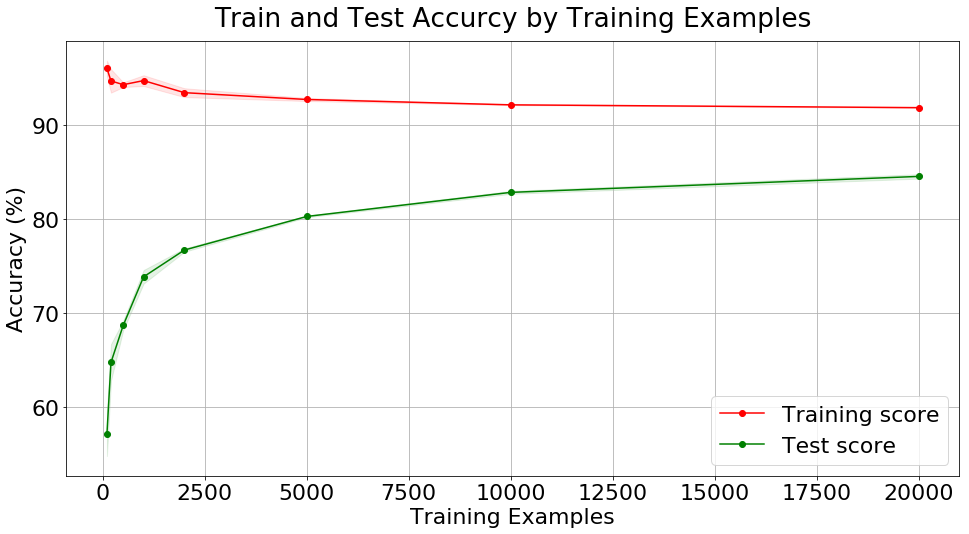

In [ ]:
# This code trains models using a range of training set sizes and plots the train and test accuracy.

# Here's the model we're going to evaluate
rf_clf_v1_lc = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=8, # How many trees? More is better, but slower.
    n_jobs=-1
)

# This function trains multiple models, 3 for each train size, and returns train and test score.
train_sizes, train_scores, test_scores = model_selection.learning_curve(
    rf_clf_v1_lc,
    rga_TRAIN_df[features],
    rga_TRAIN_df['label'],
    cv=3,
    train_sizes=[100, 200, 500, 1000, 2000, 5000, 10000, 20000]
)

# We average together scores from the 3 runs at each size
train_scores_mean = 100*train_scores.mean(axis=1)
train_scores_std = 100*train_scores.std(axis=1)
test_scores_mean = 100*test_scores.mean(axis=1)
test_scores_std = 100*test_scores.std(axis=1)

# Finally, let's plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.title('Train and Test Accurcy by Training Examples', y=1.02)
matplotlib.pyplot.xlabel('Training Examples')
matplotlib.pyplot.ylabel('Accuracy (%)')
matplotlib.pyplot.grid()
matplotlib.pyplot.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
matplotlib.pyplot.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
matplotlib.pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
matplotlib.pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")
_ = matplotlib.pyplot.legend(loc="best")

### Model version 2: learn from version 1

What does model v1 miss?

In [62]:
rga_TRAIN_df[rga_TRAIN_df['label']!=rf_v1_predictions_train][['subject', 'label']].sample(30)

,subject,label
90264,Notice,spam
11545,RE: eNYMEX,ham
59592,RE: priorities for 1/16 and accomplishments fo...,ham
38917,RE: 2 things,ham
55301,RE: Big Pig,ham
36544,Dynegy Discussions,ham
74289,St0ck Maven Newsletter,spam
80926,To comb as smacker,spam
35148,快樂的最佳去趾watson@enron.com,spam
61719,Second Cataract Surgery,ham


In [63]:
def add_features_v2(df):
    df['feature_ALL_CAPS'] = (df['subject'] == df['subject'].str.upper()).astype(int)
    df['feature_all_lower'] = (df['subject'] == df['subject'].str.lower()).astype(int)
    df['feature_all_ascii_chars'] = df['subject'].map(lambda s: all(ord(c) < 128 for c in s)).astype(int)
    df['feature_$'] = df['subject'].map(lambda x: '$' in x).astype(int)
    df['feature_@'] = df['subject'].map(lambda x: '@' in x).astype(int)
    df['feature_0'] = df['subject'].map(lambda x: '0' in x).astype(int)
    df['feature_:)'] = df['subject'].map(lambda x: ':)' in x).astype(int)
    df['feature_memy'] = df['subject'].str.lower().map(lambda x: 'me' in x or 'my' in x).astype(int)
    df['feature_re'] = df['subject'].str.lower().map(lambda s: s.startswith('re:')).astype(int)
    df['feature_fwd'] = df['subject'].str.lower().map(lambda s: s.startswith('fw:') or s.startswith('fwd:')).astype(int)

add_features_v2(rga_TRAIN_df)
add_features_v2(rga_TEST_df)

In [64]:
pd.crosstab(rga_TRAIN_df['feature_all_ascii_chars'], rga_TRAIN_df['label'])

label,ham,spam
feature_all_ascii_chars,,
0,12,11019
1,29791,29970


In [65]:
pd.crosstab(rga_TRAIN_df['feature_fwd'], rga_TRAIN_df['label'])

label,ham,spam
feature_fwd,,
0,25654,40659
1,4149,330


In [66]:
# Our features have changed, so let's get the new set of names
features = [col for col in rga_TRAIN_df if col.startswith('feature')]

# Create a new classifier
rf_clf_v2 = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=32, # How many trees? More is better, but slower.
    n_jobs=-1
)

# Fit our training data
rf_clf_v2.fit(rga_TRAIN_df[features], rga_TRAIN_df['label'])

# Make predictions on train and test
rf_v2_predictions_train = rf_clf_v2.predict(rga_TRAIN_df[features])
rf_v2_predictions_test = rf_clf_v2.predict(rga_TEST_df[features])

# Evaluate performance
rf_v2_acc_train = metrics.accuracy_score(rga_TRAIN_df['label'], rf_v2_predictions_train)
rf_v2_acc_test = metrics.accuracy_score(rga_TEST_df['label'], rf_v2_predictions_test)

# Print results
print('Random Forest v2 TRAIN accuracy is: %.2f%%' % (rf_v2_acc_train*100))
print('Random Forest v2 TEST accuracy is: %.2f%%' % (rf_v2_acc_test*100))

Random Forest v2 TRAIN accuracy is: 95.96%
Random Forest v2 TEST accuracy is: 92.10%


### Model v3: ml can utilize very basic features

In [67]:
def add_features_v3(df):
    """A bunch of features that aren't particularly human-friendly."""
    df['feature_len'] = df['subject'].map(len)
    df['feature_words'] = df['subject'].map(lambda x: len(x.split()))
    df['feature_chars_per_word'] = (df['feature_len'] / df['feature_words']).fillna(0.)
    df['feature_digits'] = df['subject'].map(lambda x: sum(c.isdigit() for c in x))
    df['feature_punc'] = df['subject'].map(lambda s: sum([1 for x in s if x in set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')]))
    
add_features_v3(rga_TRAIN_df)
add_features_v3(rga_TEST_df)

In [68]:
# Our features have changed, so let's get the new set of names
features = [col for col in rga_TRAIN_df if col.startswith('feature')]

# Create a new classifier
rf_clf_v3 = ensemble.RandomForestClassifier( # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    n_estimators=32, # How many trees? More is better, but slower.
    n_jobs=-1
)

# Fit our training data
rf_clf_v3.fit(rga_TRAIN_df[features], rga_TRAIN_df['label'])

# Make predictions on train and test
rf_v3_predictions_train = rf_clf_v3.predict(rga_TRAIN_df[features])
rf_v3_predictions_test = rf_clf_v3.predict(rga_TEST_df[features])

# Evaluate performance
rf_v3_acc_train = metrics.accuracy_score(rga_TRAIN_df['label'], rf_v3_predictions_train)
rf_v3_acc_test = metrics.accuracy_score(rga_TEST_df['label'], rf_v3_predictions_test)

# Print results
print('Random Forest v3 TRAIN accuracy is: %.2f%%' % (rf_v3_acc_train*100))
print('Random Forest v3 TEST accuracy is: %.2f%%' % (rf_v3_acc_test*100))

Random Forest v3 TRAIN accuracy is: 99.47%
Random Forest v3 TEST accuracy is: 94.31%


In [ ]:
rga_TEST_df[rga_TEST_df['label']!=rf_v3_predictions_test][['subject', 'label']].sample(30)

Let's see how we did today:

In [69]:
results_summary_df = pd.DataFrame({
    'Model': ['Always Spam', 'Simple v1', 'Simple v2', 'RF v1', 'RF v2', 'RF v3'],
    'Train Accuracy': [100*always_spam_acc_train, 100*simple_acc_train, 100*simple_v2_acc_train, 100*rf_v1_acc_train, 100*rf_v2_acc_train, 100*rf_v3_acc_train],
    'Test Accuracy': [100*always_spam_acc_test, 100*simple_acc_test, 100*simple_v2_acc_test, 100*rf_v1_acc_test, 100*rf_v2_acc_test, 100*rf_v3_acc_test]
})
results_summary_df

,Model,Test Accuracy,Train Accuracy
0,Always Spam,58.398780,57.900610
1,Simple v1,60.477993,61.071873
2,Simple v2,81.863382,82.126511
3,RF v1,87.473869,91.554130
4,RF v2,92.095599,95.958583
5,RF v3,94.310413,99.473104


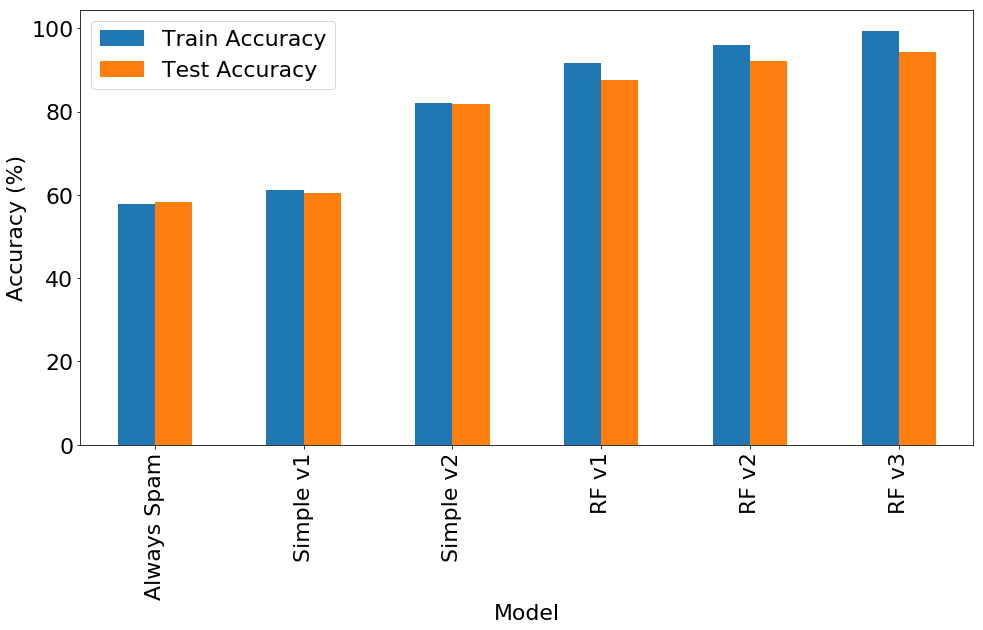

In [70]:
ax = results_summary_df.plot.bar('Model', ['Train Accuracy', 'Test Accuracy'])

_ = ax.set_ylabel('Accuracy (%)')

We started with a model that's barely better than guessing, and ended by building a machine learning model with greater than 90% accuracy. That's not the end, though; it is possible to acheive even better performance with this data, and I encourage everyone to start experimenting with new and better features as a way to learn.

# Learn More
I hope this intro has whetted your appetite. There are _tons_ of free resources online to learn more about these topics. Here are some of my favoriate.

* As mentioned previously, [Learn Python the Hard Way](https://learnpythonthehardway.org/book/) is a great resource for learning Python.
* [A visual introduction to machine learning](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) is a fun way to build a little more intuition around basic ML concepts.
* Check out these [tutorials](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) to learn more about notebooks and pandas.
* Once you have some familiarity with the basics of Python and ML, [scikit-learn's tutorials](http://scikit-learn.org/stable/tutorial/index.html) are good for building hands-on ML knowledge.
* In this training, we've pretty much exclusively used "error" and "accuracy" to evaluate machine learning models. That's not always the best thing to do. Read [Why accuracy alone is a bad measure for classification tasks, and what we can do about it](https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/) to learn why.
* Building intuition around bias and variance is an important fundamental skill. Start with Scott Fortmann-Roe's essay [Understanding the Bias-Variance Tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).
* I also highly recommend reading this paper, [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf), when you are ready to start using ML on your own.
* Finally, if you prefer a more formal classroom setting, [Andrew Ng's Coursera course on machine learning](https://www.coursera.org/learn/machine-learning) is a fantastic place to start. It's free!

# Extra Credit

In [ ]:
# Let's get more detailed information about the performance of our best model.
# Would you use it in production? Probably not.
print(metrics.classification_report(
    rga_TEST_df['label'], 
    rf_v3_predictions_test,
    digits=4
))

In [ ]:
# What if we could make sure the classifier only said 'spam' if it was particularly sure?
# We can do that by adjusting the probability threshold.

def probs_to_class(probs, threshold=0.5):
    # Converts raw spam probability to a label
    if probs > threshold:
        return 'spam'
    else:
        return 'ham'

pd.Series(rf_clf_v3.predict_proba(rga_TEST_df.head()[features])[:, 1]).map(probs_to_class)

In [ ]:
# By default, the classifier's threshold is 0.5.
# That means if the estimated spam probability is greater than 50%, label as spam.
print(metrics.classification_report(
    rga_TEST_df['label'],
    pd.Series(rf_clf_v3.predict_proba(rga_TEST_df[features])[:, 1]).map(
        lambda p: probs_to_class(p, 0.5)
    ),
    digits=4
))

In [ ]:
# Let's look at the distribution of probabilities in our test set.

ax = pd.Series(rf_clf_v3.predict_proba(rga_TEST_df[features])[:, 1]).plot.hist(bins=50, edgecolor='white')

In [ ]:
# Choosing a higher threshold gets you precision, but at the cost of recall.
print(metrics.classification_report(
    rga_TEST_df['label'],
    pd.Series(rf_clf_v3.predict_proba(rga_TEST_df[features])[:, 1]).map(
        lambda p: probs_to_class(p, 0.97)
    ),
    digits=3
))

## A note on running a model like this in production

With an adjusted threshold, this model is close to being suitable for real-world abuse detection as part of a broader portfolio of abuse detection techniques. However, there are a few things I would do before considering using this model in production:

1. Most importantly, the training set needs to be augmented with data from the actual mailstream you will be filtering. Every mailstream is different, and a ML model trained on one source of mail will perform worse, if not poorly, on a different one. The best thing you can do for your model is to gather and label your own training data, rather than relying on what is available from other sources. As a general rule of thumb (which you should test for yourself!), you should try to ensure that non-native data makes up no more than one-third of your training set. That means you need to collect a lot more samples. It takes less time than you would think; most people underestimate the value of simply spending time manually labeling more training samples.

2. Many of the features are based on particular words. We know that spammers try to avoid filtering by using variations on key words and phrases. Building features that are a little more flexible (for example, a feature that will catch "viagra" and anything within one letter substition of that word) is a good idea. Be careful, though: being too flexible with certain words can cause trouble. For example, "meds" and "beds" are only one letter apart.

3. Use more of the email. To keep things simple, we focused on subject lines, but using just the subject line is a bit like playing with one hand tied behind our backs. The rest of the email header and the email content contain many rich features that will improve your model.

If you follow this advice, it is possible to improve performance by at least an order of magnitude, which allows you to either reduce false positive rates while keeping spam detection rates the same, or boost spam detection rates while keeping false positive rates the same, or something in between, depending on how you pick your threshold.

Deployment of ML models (i.e., actually running them on a server, not just in the notebook environment), is a big topic. This article, [Deploying a scikit-learn classifier to production](https://loads.pickle.me.uk/2016/04/04/deploying-a-scikit-learn-classifier-to-production/), is a good place to start.